In [56]:
#https://medium.com/@codetrade/grad-cam-in-pytorch-a-powerful-tool-for-visualize-explanations-from-deep-networks-bdc7caf0b282
#https://www.codetrade.io/blog/grad-cam-a-complete-guide-with-example/
#https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353
#https://github.com/jacobgil/pytorch-grad-cam
#https://arxiv.org/pdf/1610.02391
#https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb

In [57]:
import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [58]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [59]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [60]:
from torch import nn

class FashionMnistModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units,
                        hidden_units,
                        3,
                        padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units,
                        hidden_units,
                        3,
                        padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                        out_features=output_shape),
        )
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [61]:
model = FashionMnistModel(1, 10, 10)

In [62]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [63]:
# Import accuracy metric
from helper_functions import accuracy_fn

In [64]:
accuracy_fn(
    torch.tensor([0, 1, 2, 3]),
    torch.tensor([0, 1, 2, 2])
)

75.0

In [65]:
epochs = 1

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f'looked at {batch * len(X)} / {len(train_dataloader.dataset)}')

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Train Error: {train_loss:.4f}, Test Error: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1
-------------------------------
looked at 0 / 60000
looked at 3200 / 60000
looked at 6400 / 60000
looked at 9600 / 60000
looked at 12800 / 60000
looked at 16000 / 60000
looked at 19200 / 60000
looked at 22400 / 60000
looked at 25600 / 60000
looked at 28800 / 60000
looked at 32000 / 60000
looked at 35200 / 60000
looked at 38400 / 60000
looked at 41600 / 60000
looked at 44800 / 60000
looked at 48000 / 60000
looked at 51200 / 60000
looked at 54400 / 60000
looked at 57600 / 60000
Train Error: 0.4455, Test Error: 0.3802, Test Accuracy: 86.2420


In [66]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 10, 28, 28]             910
              ReLU-4           [-1, 10, 28, 28]               0
         MaxPool2d-5           [-1, 10, 14, 14]               0
            Conv2d-6           [-1, 10, 14, 14]             910
              ReLU-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             910
              ReLU-9           [-1, 10, 14, 14]               0
        MaxPool2d-10             [-1, 10, 7, 7]               0
          Flatten-11                  [-1, 490]               0
           Linear-12                   [-1, 10]           4,910
Total params: 7,740
Trainable params: 7,740
Non-trainable params: 0
-----------------------------------

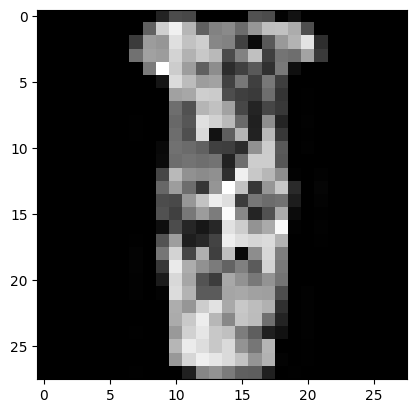

In [67]:
img = test_data[100][0].unsqueeze(0)
y = test_data.targets[100]
plt.imshow(img.squeeze(0).squeeze(0), cmap='gray')
class

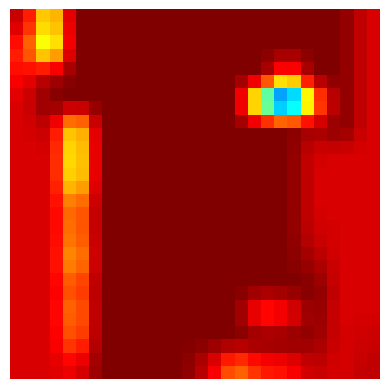

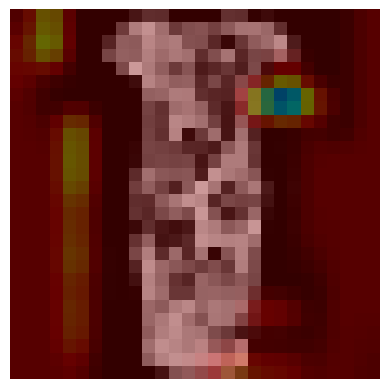

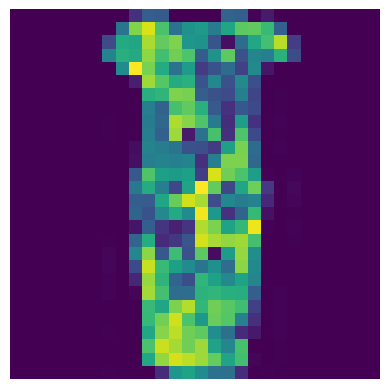

In [68]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Assuming your model and input image `img` are already defined
target_layer = model.block_2[-3]
# Hook functions for forward and backward passes
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

# Set the model in evaluation mode
model.eval()

# Forward pass
output = model(img)
pred_class = output.argmax(dim=1).item()

# Zero the gradients
model.zero_grad()

# Backward pass (compute gradients)
output[:, pred_class].backward()

# Get the gradients and activations
gradients = gradients[0].cpu().data.numpy()
activations = activations[0].cpu().data.numpy()

# Compute the Grad-CAM
weights = np.mean(gradients, axis=(2, 3))  # Global average pooling of gradients
grad_cam = np.zeros(activations.shape[2:], dtype=np.float32)

# Weighted sum of the activations
for i, w in enumerate(weights[0]):
    grad_cam += w * activations[0, i, :, :]

# ReLU activation
grad_cam = np.maximum(grad_cam, 0)

# Normalize the heatmap
grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())

# Resize heatmap to the size of the original image
heatmap = cv2.resize(grad_cam, (img.shape[2], img.shape[3]))

# Convert heatmap to RGB
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

# Plot the heatmap
plt.imshow(heatmap)
plt.axis('off')
plt.show()

img_np = img.cpu().squeeze().numpy()  # Shape: (28, 28)

# Optionally, you can normalize the image if needed
# img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Overlay the heatmap (reshaped to 28x28) on the grayscale image
overlayed_img = heatmap * 0.4 + np.stack([img_np] * 3, axis=-1) * 0.6  # Replicating the grayscale image into 3 channels

# Plot overlayed image
plt.imshow(np.clip(overlayed_img, 0, 1))
plt.axis('off')
plt.show()

plt.imshow(img.squeeze())
plt.axis('off')
plt.show()